## 第零部分 初始化

In [44]:
# import packages
import pandas as pd
import numpy as np

# to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [45]:
# read the file
df = pd.read_csv('../res/input1016.csv')

# print the head
df.head()

,xau,date,lag1,lag2,lag3,cbv,ccu,cfi2z,clq,ctv,...,lsu,ngq,rbq,sp500,tyvix,usd,usu,zcu,zsq,zwu
0,0.000000,1979/1/1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.353357,1979/1/2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.682500,1979/1/3,0.353357,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.060062,1979/1/4,-3.682500,0.353357,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.047597,1979/1/5,2.060062,-3.682500,0.353357,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


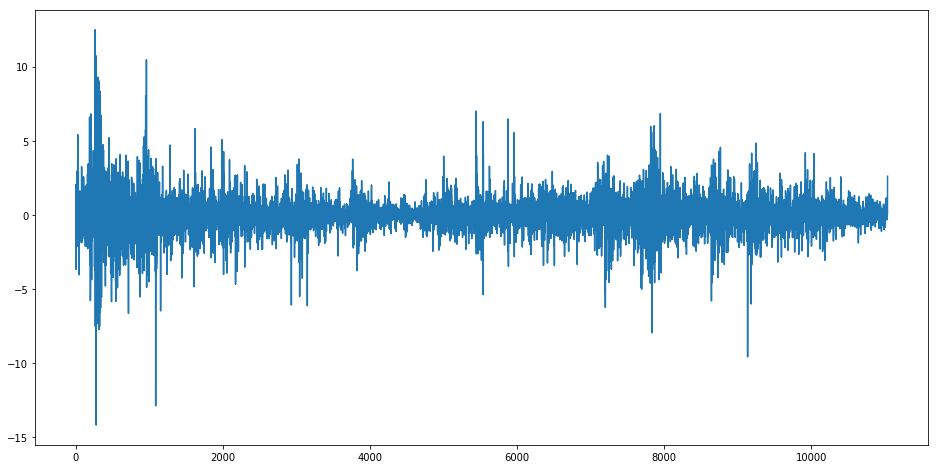

In [46]:
# setting index as date
# df['Ndate'] = pd.to_datetime(df.Ndate,format='%Y-%m-%d')
# df.index = df['Ndate']

# plot
plt.figure(figsize=(16,8))
plt.plot(df['xau'], label='Price History')

In [47]:
# splitting into train and validation
train = df[:5500].copy()
valid = df[5500:].copy()

df.shape, train.shape, valid.shape

((11039, 33), (5500, 33), (5539, 33))

## 第一部分 滑动平均

In [90]:
#make predictions
preds = []
for i in range(0,5539):
    a = train['xau'][len(train)-5539+i:].sum() + sum(preds)
    b = a/5539
    preds.append(b)
preds

[-0.001710422632785701,
 -0.001465017145627872,
 -0.0014384358322401902,
 -0.0014147990282741747,
 -0.0010771392348147548,
 -0.0007205519284841563,
 -0.0010683249349706131,
 -0.0012413698246501528,
 -0.0007676334398920105,
 -0.0007305540779927313,
 -0.0007462027747029666,
 -0.0007215042007319798,
 -0.000665634344837546,
 -0.0005751651394475546,
 -0.0007311749589347269,
 -0.0010391371038993298,
 -0.0010545792927608387,
 -0.0007627052424435903,
 -0.0007411343392557305,
 -0.0009479874171288582,
 -0.000911307794528593,
 -0.0009083980246774515,
 -0.0009177833415261026,
 -0.0009884897541170984,
 -0.001131965194585435,
 -0.0011473471960648692,
 -0.0012020884275499868,
 -0.0011082829260926025,
 -0.0008265303077365985,
 -0.0007709960694819922,
 -0.0006342927111265998,
 -0.0004366499804371481,
 -0.00023039742004365413,
 0.00019924136106845209,
 -5.530738523339062e-06,
 -0.00011510529922717067,
 1.061747901813945e-05,
 -9.583591320446065e-05,
 -2.172343024963206e-05,
 0.0039401203506800936,
 0.00

In [91]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['xau'])-preds),2)))
rms

1.004162729040933

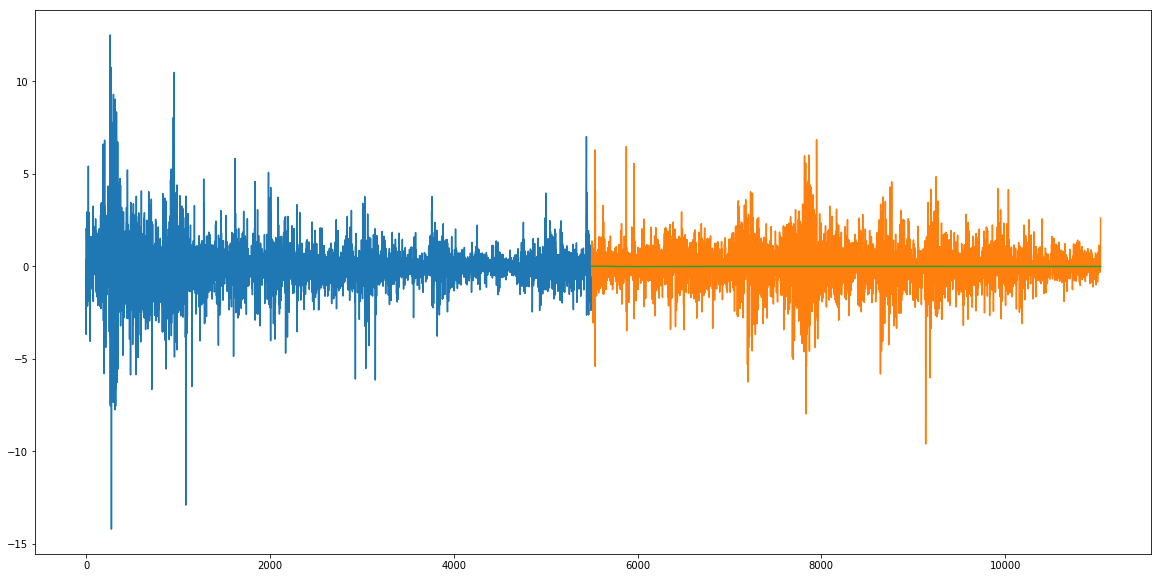

In [92]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['xau'])
plt.plot(valid[['xau', 'Predictions']])

## 第二部分 长短期记忆网络(LSTM)

In [49]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 

In [50]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['xau'])
for i in range(0,len(data)):
    new_data['xau'][i] = data['xau'][i]

In [51]:
#creating train and test sets
dataset = new_data.values
train = dataset[0:5500,:]
valid = dataset[5500:,:] 

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))

In [52]:
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

G:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1024, batch_size=5, verbose=2)

Epoch 1/1024
 - 43s - loss: 0.0036
Epoch 2/1024
 - 40s - loss: 0.0026
Epoch 3/1024
 - 40s - loss: 0.0025
Epoch 4/1024
 - 40s - loss: 0.0025
Epoch 5/1024
 - 40s - loss: 0.0024
Epoch 6/1024
 - 41s - loss: 0.0024
Epoch 7/1024
 - 40s - loss: 0.0024
Epoch 8/1024
 - 40s - loss: 0.0024
Epoch 9/1024
 - 41s - loss: 0.0024
Epoch 10/1024
 - 40s - loss: 0.0024
Epoch 11/1024
 - 41s - loss: 0.0024
Epoch 12/1024
 - 40s - loss: 0.0024
Epoch 13/1024
 - 40s - loss: 0.0024
Epoch 14/1024
 - 40s - loss: 0.0024
Epoch 15/1024
 - 40s - loss: 0.0024
Epoch 16/1024
 - 40s - loss: 0.0024
Epoch 17/1024
 - 40s - loss: 0.0024
Epoch 18/1024
 - 40s - loss: 0.0023
Epoch 19/1024
 - 40s - loss: 0.0023
Epoch 20/1024
 - 40s - loss: 0.0023
Epoch 21/1024
 - 41s - loss: 0.0023
Epoch 22/1024
 - 40s - loss: 0.0024
Epoch 23/1024
 - 41s - loss: 0.0023
Epoch 24/1024
 - 41s - loss: 0.0024
Epoch 25/1024
 - 41s - loss: 0.0024
Epoch 26/1024
 - 41s - loss: 0.0023
Epoch 27/1024
 - 41s - loss: 0.0023
Epoch 28/1024
 - 42s - loss: 0.0023
E

 - 40s - loss: 0.0015
Epoch 226/1024
 - 40s - loss: 0.0015
Epoch 227/1024
 - 41s - loss: 0.0015
Epoch 228/1024
 - 40s - loss: 0.0015
Epoch 229/1024
 - 41s - loss: 0.0015
Epoch 230/1024
 - 41s - loss: 0.0015
Epoch 231/1024
 - 41s - loss: 0.0015
Epoch 232/1024
 - 40s - loss: 0.0015
Epoch 233/1024
 - 41s - loss: 0.0014
Epoch 234/1024
 - 41s - loss: 0.0014
Epoch 235/1024
 - 41s - loss: 0.0015
Epoch 236/1024
 - 41s - loss: 0.0014
Epoch 237/1024
 - 41s - loss: 0.0014
Epoch 238/1024
 - 41s - loss: 0.0015
Epoch 239/1024
 - 41s - loss: 0.0014
Epoch 240/1024
 - 41s - loss: 0.0014
Epoch 241/1024
 - 41s - loss: 0.0014
Epoch 242/1024
 - 41s - loss: 0.0014
Epoch 243/1024
 - 41s - loss: 0.0014
Epoch 244/1024
 - 41s - loss: 0.0014
Epoch 245/1024
 - 41s - loss: 0.0014
Epoch 246/1024
 - 41s - loss: 0.0013
Epoch 247/1024
 - 41s - loss: 0.0014
Epoch 248/1024
 - 41s - loss: 0.0013
Epoch 249/1024
 - 41s - loss: 0.0013
Epoch 250/1024
 - 41s - loss: 0.0013
Epoch 251/1024
 - 41s - loss: 0.0013
Epoch 252/1024
 

Epoch 433/1024
 - 41s - loss: 3.8180e-04
Epoch 434/1024
 - 41s - loss: 3.5159e-04
Epoch 435/1024
 - 41s - loss: 3.4926e-04
Epoch 436/1024
 - 41s - loss: 3.6189e-04
Epoch 437/1024
 - 41s - loss: 3.5109e-04
Epoch 438/1024
 - 41s - loss: 3.4768e-04
Epoch 439/1024
 - 45s - loss: 3.4850e-04
Epoch 440/1024
 - 41s - loss: 3.3558e-04
Epoch 441/1024
 - 41s - loss: 3.3115e-04
Epoch 442/1024
 - 41s - loss: 3.2891e-04
Epoch 443/1024
 - 41s - loss: 3.3504e-04
Epoch 444/1024
 - 40s - loss: 3.2808e-04
Epoch 445/1024
 - 41s - loss: 3.3090e-04
Epoch 446/1024
 - 41s - loss: 3.2409e-04
Epoch 447/1024
 - 41s - loss: 3.2247e-04
Epoch 448/1024
 - 41s - loss: 3.2767e-04
Epoch 449/1024
 - 41s - loss: 3.2567e-04
Epoch 450/1024
 - 41s - loss: 3.1381e-04
Epoch 451/1024
 - 41s - loss: 3.1292e-04
Epoch 452/1024
 - 41s - loss: 2.9334e-04
Epoch 453/1024
 - 41s - loss: 3.1142e-04
Epoch 454/1024
 - 41s - loss: 3.1394e-04
Epoch 455/1024
 - 41s - loss: 3.0133e-04
Epoch 456/1024
 - 41s - loss: 3.0337e-04
Epoch 457/1024
 

Epoch 633/1024
 - 41s - loss: 9.4545e-05
Epoch 634/1024
 - 41s - loss: 9.1228e-05
Epoch 635/1024
 - 42s - loss: 8.9361e-05
Epoch 636/1024
 - 41s - loss: 8.8437e-05
Epoch 637/1024
 - 41s - loss: 1.1334e-04
Epoch 638/1024
 - 41s - loss: 7.8970e-05
Epoch 639/1024
 - 41s - loss: 9.3516e-05
Epoch 640/1024
 - 41s - loss: 8.9135e-05
Epoch 641/1024
 - 41s - loss: 9.0514e-05
Epoch 642/1024
 - 41s - loss: 8.4486e-05
Epoch 643/1024
 - 41s - loss: 8.5593e-05
Epoch 644/1024
 - 41s - loss: 8.4161e-05
Epoch 645/1024
 - 44s - loss: 8.8808e-05
Epoch 646/1024
 - 40s - loss: 8.6170e-05
Epoch 647/1024
 - 40s - loss: 8.1510e-05
Epoch 648/1024
 - 41s - loss: 8.6924e-05
Epoch 649/1024
 - 43s - loss: 8.5971e-05
Epoch 650/1024
 - 42s - loss: 8.3191e-05
Epoch 651/1024
 - 40s - loss: 9.3135e-05
Epoch 652/1024
 - 41s - loss: 8.6553e-05
Epoch 653/1024
 - 40s - loss: 8.0763e-05
Epoch 654/1024
 - 41s - loss: 8.0520e-05
Epoch 655/1024
 - 41s - loss: 8.0435e-05
Epoch 656/1024
 - 41s - loss: 7.6428e-05
Epoch 657/1024
 

In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []

for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

In [ ]:
#for plotting
rcParams['figure.figsize'] = 20,10
train = new_data[:5500].copy()
valid = new_data[5500:].copy()
valid['Predictions'] = closing_price
plt.plot(train['xau'])
plt.plot(valid[['xau','Predictions']])

In [ ]:
type(valid)

In [ ]:
valid.to_csv('LSTM_predict_v4.csv')

## 第三部分 神经网络

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
import keras as k
df = pd.read_csv('../res/input1017.csv')

In [4]:
df.head()

,lag1,lag2,lag3,cbv,ccu,cfi2z,clq,ctv,djci,dji,...,ngq,rbq,sp500,tyvix,usd,usu,zcu,zsq,zwu,Target
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.353357,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-3.682500,0.353357,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2.060062,-3.682500,0.353357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
Y_PRED = []
Y_TEST = []
accuracy = []
precision = []
recall = []
f1 = []
df = df.reindex(np.random.permutation(df.index))
# 黄金价格涨跌放在最后一列，列名叫‘Target’，涨和不变记为1，跌记为0
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [8]:
# 填参数的数目
num_parameters = 31

In [38]:
# 十折
sfolder = StratifiedKFold(n_splits=10, shuffle=True, random_state=1218)
all_y_test = []
for train, test in sfolder.split(x, y):
    batch_size = 64
    max_epochs = 1024
    model = k.models.Sequential()
    # 每层神经元数可调
    model.add(k.layers.Dense(units=32, activation='relu', use_bias=True, input_shape=(num_parameters, )))
    model.add(k.layers.normalization.BatchNormalization(epsilon=1e-6))
    model.add(k.layers.Dense(units=32, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization())
    model.add(k.layers.Dense(units=32, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization(epsilon=1e-6))
    model.add(k.layers.Dense(units=32, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization())
    model.add(k.layers.Dropout(0.5))
    model.add(k.layers.Dense(units=2, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    x_train = x.iloc[train.tolist(), :]
    y_train = y.iloc[train.tolist()]
    model.fit(x_train, np_utils.to_categorical(y_train, num_classes=2), batch_size=batch_size, epochs=max_epochs, shuffle=True, verbose=1)
    x_test = x.iloc[test.tolist(), :]
    y_test = y.iloc[test.tolist()]
    y_test = y_test.reset_index()['Target']
    y_pred = model.predict(x_test)
    test_0_num = 0
    test_0_pred_0 = 0
    test_1_num = 0
    test_1_pred_1 = 0
    for index in range(0, len(y_test)):
        if y_test[index] == 0:
            test_0_num = test_0_num + 1
            if y_pred[index][0] < 0.5:
                test_0_pred_0 = test_0_pred_0 + 1
        else:
            test_1_num = test_1_num + 1
            if y_pred[index][1] > 0.5:
                test_1_pred_1 = test_1_pred_1 + 1
    accuracy = accuracy + [(test_1_pred_1 + test_0_pred_0) / (test_0_num + test_1_num)]
    precision = precision + [test_1_pred_1 / (test_1_pred_1 + test_0_num - test_0_pred_0)]
    recall = recall + [test_1_pred_1 / (test_1_pred_1 + test_0_pred_0)]

Epoch 1/1024
9934/9934 [==============================] - 2s 162us/step - loss: 0.3003 - mae: 0.4714
Epoch 2/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.2566 - mae: 0.4429
Epoch 3/1024
9934/9934 [==============================] - 1s 57us/step - loss: 0.2367 - mae: 0.4282
Epoch 4/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.2238 - mae: 0.4184
Epoch 5/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.2156 - mae: 0.4113
Epoch 6/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.2136 - mae: 0.4129
Epoch 7/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.2088 - mae: 0.4083
Epoch 8/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.2073 - mae: 0.4067
Epoch 9/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.2047 - mae: 0.4044
Epoch 10/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.2027 - mae: 0.401

9934/9934 [==============================] - 1s 69us/step - loss: 0.1591 - mae: 0.3114
Epoch 82/1024
9934/9934 [==============================] - 1s 81us/step - loss: 0.1601 - mae: 0.3139
Epoch 83/1024
9934/9934 [==============================] - 1s 67us/step - loss: 0.1570 - mae: 0.3088
Epoch 84/1024
9934/9934 [==============================] - 1s 60us/step - loss: 0.1587 - mae: 0.3093
Epoch 85/1024
9934/9934 [==============================] - 1s 63us/step - loss: 0.1599 - mae: 0.3139
Epoch 86/1024
9934/9934 [==============================] - 1s 66us/step - loss: 0.1575 - mae: 0.3103
Epoch 87/1024
9934/9934 [==============================] - 1s 51us/step - loss: 0.1577 - mae: 0.3090
Epoch 88/1024
9934/9934 [==============================] - 1s 59us/step - loss: 0.1585 - mae: 0.3115
Epoch 89/1024
9934/9934 [==============================] - 1s 57us/step - loss: 0.1580 - mae: 0.3105
Epoch 90/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1566 - mae: 0.3099
Epoc

9934/9934 [==============================] - 0s 50us/step - loss: 0.1431 - mae: 0.2780
Epoch 162/1024
9934/9934 [==============================] - 1s 57us/step - loss: 0.1450 - mae: 0.2820
Epoch 163/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1432 - mae: 0.2810
Epoch 164/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1448 - mae: 0.2815
Epoch 165/1024
9934/9934 [==============================] - 1s 58us/step - loss: 0.1446 - mae: 0.2816
Epoch 166/1024
9934/9934 [==============================] - 1s 55us/step - loss: 0.1424 - mae: 0.2794
Epoch 167/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1424 - mae: 0.2754
Epoch 168/1024
9934/9934 [==============================] - 1s 61us/step - loss: 0.1435 - mae: 0.2822
Epoch 169/1024
9934/9934 [==============================] - 1s 53us/step - loss: 0.1443 - mae: 0.2817: 0s - loss: 0.1305 - ma
Epoch 170/1024
9934/9934 [==============================] - 1s 53us/step 

9934/9934 [==============================] - 1s 52us/step - loss: 0.1386 - mae: 0.2694
Epoch 242/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1396 - mae: 0.2752
Epoch 243/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1366 - mae: 0.2675
Epoch 244/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1377 - mae: 0.2672
Epoch 245/1024
9934/9934 [==============================] - 1s 57us/step - loss: 0.1412 - mae: 0.2724
Epoch 246/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1382 - mae: 0.2676
Epoch 247/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1369 - mae: 0.2677
Epoch 248/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1355 - mae: 0.2659
Epoch 249/1024
9934/9934 [==============================] - 1s 57us/step - loss: 0.1394 - mae: 0.2702: 0s - loss: 0.1381 - ma
Epoch 250/1024
9934/9934 [==============================] - 1s 55us/step 

9934/9934 [==============================] - 0s 46us/step - loss: 0.1343 - mae: 0.2633
Epoch 320/1024
9934/9934 [==============================] - 1s 54us/step - loss: 0.1335 - mae: 0.2606
Epoch 321/1024
9934/9934 [==============================] - 1s 52us/step - loss: 0.1335 - mae: 0.2586
Epoch 322/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1336 - mae: 0.2603
Epoch 323/1024
9934/9934 [==============================] - 1s 54us/step - loss: 0.1313 - mae: 0.2570
Epoch 324/1024
9934/9934 [==============================] - 1s 56us/step - loss: 0.1336 - mae: 0.2576
Epoch 325/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1350 - mae: 0.2618
Epoch 326/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1351 - mae: 0.2622
Epoch 327/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1357 - mae: 0.2641
Epoch 328/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1346 - mae: 0.

9934/9934 [==============================] - 0s 47us/step - loss: 0.1306 - mae: 0.2550
Epoch 399/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1294 - mae: 0.2529
Epoch 400/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1298 - mae: 0.2529
Epoch 401/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1324 - mae: 0.2559
Epoch 402/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1308 - mae: 0.2567
Epoch 403/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1295 - mae: 0.2542
Epoch 404/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1321 - mae: 0.2555
Epoch 405/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1287 - mae: 0.2517
Epoch 406/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1310 - mae: 0.2532
Epoch 407/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1298 - mae: 0.

9934/9934 [==============================] - 1s 53us/step - loss: 0.1265 - mae: 0.2470
Epoch 478/1024
9934/9934 [==============================] - 1s 53us/step - loss: 0.1296 - mae: 0.2497
Epoch 479/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1275 - mae: 0.2478
Epoch 480/1024
9934/9934 [==============================] - 1s 52us/step - loss: 0.1293 - mae: 0.2518
Epoch 481/1024
9934/9934 [==============================] - 1s 54us/step - loss: 0.1293 - mae: 0.2507
Epoch 482/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1261 - mae: 0.2469
Epoch 483/1024
9934/9934 [==============================] - 1s 56us/step - loss: 0.1295 - mae: 0.2506
Epoch 484/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1279 - mae: 0.2494
Epoch 485/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1285 - mae: 0.2491
Epoch 486/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1260 - mae: 0.

9934/9934 [==============================] - 0s 50us/step - loss: 0.1283 - mae: 0.2517
Epoch 557/1024
9934/9934 [==============================] - 1s 53us/step - loss: 0.1279 - mae: 0.2469
Epoch 558/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1263 - mae: 0.2450
Epoch 559/1024
9934/9934 [==============================] - 1s 51us/step - loss: 0.1242 - mae: 0.2408
Epoch 560/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1272 - mae: 0.2467
Epoch 561/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1259 - mae: 0.2446
Epoch 562/1024
9934/9934 [==============================] - 1s 54us/step - loss: 0.1261 - mae: 0.2444
Epoch 563/1024
9934/9934 [==============================] - 1s 55us/step - loss: 0.1260 - mae: 0.2453
Epoch 564/1024
9934/9934 [==============================] - 1s 50us/step - loss: 0.1262 - mae: 0.2444: 0s - loss: 0.1276 - mae:
Epoch 565/1024
9934/9934 [==============================] - 0s 46us/ste

9934/9934 [==============================] - 0s 49us/step - loss: 0.1257 - mae: 0.2420
Epoch 636/1024
9934/9934 [==============================] - 1s 55us/step - loss: 0.1247 - mae: 0.2424
Epoch 637/1024
9934/9934 [==============================] - 1s 54us/step - loss: 0.1241 - mae: 0.2407
Epoch 638/1024
9934/9934 [==============================] - 1s 58us/step - loss: 0.1276 - mae: 0.2438
Epoch 639/1024
9934/9934 [==============================] - 1s 61us/step - loss: 0.1217 - mae: 0.2384
Epoch 640/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1242 - mae: 0.2407
Epoch 641/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1233 - mae: 0.2396
Epoch 642/1024
9934/9934 [==============================] - 1s 50us/step - loss: 0.1271 - mae: 0.2455
Epoch 643/1024
9934/9934 [==============================] - 1s 55us/step - loss: 0.1268 - mae: 0.2463
Epoch 644/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1238 - mae: 0.

9934/9934 [==============================] - 0s 47us/step - loss: 0.1283 - mae: 0.2422
Epoch 715/1024
9934/9934 [==============================] - 1s 52us/step - loss: 0.1217 - mae: 0.2384
Epoch 716/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1248 - mae: 0.2404
Epoch 717/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1227 - mae: 0.2389
Epoch 718/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1212 - mae: 0.2353
Epoch 719/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1241 - mae: 0.2372
Epoch 720/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1219 - mae: 0.2352
Epoch 721/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1271 - mae: 0.2456
Epoch 722/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1218 - mae: 0.2375
Epoch 723/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1251 - mae: 0.

9934/9934 [==============================] - 0s 46us/step - loss: 0.1220 - mae: 0.2363
Epoch 794/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1228 - mae: 0.2359
Epoch 795/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1222 - mae: 0.2348
Epoch 796/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1229 - mae: 0.2398
Epoch 797/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1225 - mae: 0.2377
Epoch 798/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1216 - mae: 0.2341
Epoch 799/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1244 - mae: 0.2406
Epoch 800/1024
9934/9934 [==============================] - 1s 51us/step - loss: 0.1197 - mae: 0.2327
Epoch 801/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1218 - mae: 0.2371
Epoch 802/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1248 - mae: 0.

9934/9934 [==============================] - 0s 46us/step - loss: 0.1207 - mae: 0.2341
Epoch 874/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1192 - mae: 0.2303
Epoch 875/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1203 - mae: 0.2328
Epoch 876/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1225 - mae: 0.2361
Epoch 877/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1236 - mae: 0.2383
Epoch 878/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1205 - mae: 0.2346
Epoch 879/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1214 - mae: 0.2348
Epoch 880/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1222 - mae: 0.2366
Epoch 881/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1214 - mae: 0.2342
Epoch 882/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1202 - mae: 0.

9934/9934 [==============================] - 0s 46us/step - loss: 0.1206 - mae: 0.2318
Epoch 953/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1214 - mae: 0.2341
Epoch 954/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1177 - mae: 0.2284
Epoch 955/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1212 - mae: 0.2324
Epoch 956/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1200 - mae: 0.2333
Epoch 957/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1194 - mae: 0.2308
Epoch 958/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1195 - mae: 0.2322
Epoch 959/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1200 - mae: 0.2323
Epoch 960/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1178 - mae: 0.2284
Epoch 961/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1212 - mae: 0.

9934/9934 [==============================] - 0s 45us/step - loss: 0.2060 - mae: 0.4039
Epoch 9/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.2033 - mae: 0.3998
Epoch 10/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.2019 - mae: 0.3983
Epoch 11/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.2005 - mae: 0.3967
Epoch 12/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1990 - mae: 0.3941
Epoch 13/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1970 - mae: 0.3907
Epoch 14/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1974 - mae: 0.3901
Epoch 15/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1953 - mae: 0.3872
Epoch 16/1024
9934/9934 [==============================] - 1s 51us/step - loss: 0.1943 - mae: 0.3866
Epoch 17/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1921 - mae: 0.3825
Epoch

9934/9934 [==============================] - 1s 52us/step - loss: 0.1562 - mae: 0.3069
Epoch 90/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1546 - mae: 0.3047
Epoch 91/1024
9934/9934 [==============================] - 1s 62us/step - loss: 0.1574 - mae: 0.3066
Epoch 92/1024
9934/9934 [==============================] - 1s 55us/step - loss: 0.1577 - mae: 0.3104
Epoch 93/1024
9934/9934 [==============================] - 1s 53us/step - loss: 0.1544 - mae: 0.3055
Epoch 94/1024
9934/9934 [==============================] - 1s 56us/step - loss: 0.1539 - mae: 0.3027
Epoch 95/1024
9934/9934 [==============================] - 1s 68us/step - loss: 0.1556 - mae: 0.3062
Epoch 96/1024
9934/9934 [==============================] - 1s 58us/step - loss: 0.1531 - mae: 0.3016
Epoch 97/1024
9934/9934 [==============================] - 1s 57us/step - loss: 0.1530 - mae: 0.2995
Epoch 98/1024
9934/9934 [==============================] - 1s 55us/step - loss: 0.1537 - mae: 0.3013
Epoc

9934/9934 [==============================] - 0s 48us/step - loss: 0.1444 - mae: 0.2827
Epoch 170/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1448 - mae: 0.2805
Epoch 171/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1441 - mae: 0.2806
Epoch 172/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1425 - mae: 0.2789
Epoch 173/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1416 - mae: 0.2782
Epoch 174/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1454 - mae: 0.2825
Epoch 175/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1450 - mae: 0.2836
Epoch 176/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1440 - mae: 0.2812
Epoch 177/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1451 - mae: 0.2828
Epoch 178/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1452 - mae: 0.

Epoch 249/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1380 - mae: 0.2699
Epoch 250/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1366 - mae: 0.2675
Epoch 251/1024
9934/9934 [==============================] - 1s 55us/step - loss: 0.1390 - mae: 0.2679
Epoch 252/1024
9934/9934 [==============================] - 1s 59us/step - loss: 0.1362 - mae: 0.2670
Epoch 253/1024
9934/9934 [==============================] - 1s 72us/step - loss: 0.1364 - mae: 0.2651: 1s - loss: 0.1293 -
Epoch 254/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1372 - mae: 0.2662
Epoch 255/1024
9934/9934 [==============================] - 1s 55us/step - loss: 0.1368 - mae: 0.2644
Epoch 256/1024
9934/9934 [==============================] - 1s 66us/step - loss: 0.1383 - mae: 0.2664
Epoch 257/1024
9934/9934 [==============================] - 1s 55us/step - loss: 0.1383 - mae: 0.2700
Epoch 258/1024
9934/9934 [==============================] - 1

9934/9934 [==============================] - 0s 47us/step - loss: 0.1319 - mae: 0.2550
Epoch 329/1024
9934/9934 [==============================] - 1s 60us/step - loss: 0.1342 - mae: 0.2594
Epoch 330/1024
9934/9934 [==============================] - 1s 57us/step - loss: 0.1333 - mae: 0.2600
Epoch 331/1024
9934/9934 [==============================] - 1s 55us/step - loss: 0.1318 - mae: 0.2550: 0s - loss: 0.1282 - mae: 0.
Epoch 332/1024
9934/9934 [==============================] - 1s 52us/step - loss: 0.1343 - mae: 0.2603
Epoch 333/1024
9934/9934 [==============================] - 1s 63us/step - loss: 0.1320 - mae: 0.2578
Epoch 334/1024
9934/9934 [==============================] - 1s 53us/step - loss: 0.1308 - mae: 0.2541
Epoch 335/1024
9934/9934 [==============================] - 1s 51us/step - loss: 0.1329 - mae: 0.2579
Epoch 336/1024
9934/9934 [==============================] - 1s 56us/step - loss: 0.1329 - mae: 0.2587
Epoch 337/1024
9934/9934 [==============================] - 1s 62us/

Epoch 408/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1300 - mae: 0.2528
Epoch 409/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1317 - mae: 0.2556
Epoch 410/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1325 - mae: 0.2564
Epoch 411/1024
9934/9934 [==============================] - 1s 51us/step - loss: 0.1312 - mae: 0.2535
Epoch 412/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1308 - mae: 0.2546
Epoch 413/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1318 - mae: 0.2537
Epoch 414/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1285 - mae: 0.2511
Epoch 415/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1331 - mae: 0.2565
Epoch 416/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1282 - mae: 0.2505
Epoch 417/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0

Epoch 488/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1289 - mae: 0.2496
Epoch 489/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1279 - mae: 0.2472
Epoch 490/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1279 - mae: 0.2478
Epoch 491/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1267 - mae: 0.2455
Epoch 492/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1284 - mae: 0.2485
Epoch 493/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1296 - mae: 0.2502
Epoch 494/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1293 - mae: 0.2510
Epoch 495/1024
9934/9934 [==============================] - 1s 51us/step - loss: 0.1290 - mae: 0.2501
Epoch 496/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1290 - mae: 0.2487
Epoch 497/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0

9934/9934 [==============================] - 0s 47us/step - loss: 0.1247 - mae: 0.2451
Epoch 569/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1288 - mae: 0.2489
Epoch 570/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1280 - mae: 0.2471
Epoch 571/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1249 - mae: 0.2449
Epoch 572/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1274 - mae: 0.2439
Epoch 573/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1236 - mae: 0.2406
Epoch 574/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1255 - mae: 0.2412
Epoch 575/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1267 - mae: 0.2441
Epoch 576/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1268 - mae: 0.2460
Epoch 577/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1281 - mae: 0.

9934/9934 [==============================] - 0s 49us/step - loss: 0.1254 - mae: 0.2441
Epoch 649/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1220 - mae: 0.2379
Epoch 650/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1270 - mae: 0.2449
Epoch 651/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1265 - mae: 0.2424
Epoch 652/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1242 - mae: 0.2404: 0s - loss: 0.1210 - mae: 0.
Epoch 653/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1276 - mae: 0.2468
Epoch 654/1024
9934/9934 [==============================] - ETA: 0s - loss: 0.1245 - mae: 0.242 - 0s 47us/step - loss: 0.1251 - mae: 0.2425
Epoch 655/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1241 - mae: 0.2394
Epoch 656/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1240 - mae: 0.2408
Epoch 657/1024
9934/9934 [====

9934/9934 [==============================] - 0s 45us/step - loss: 0.1208 - mae: 0.2347
Epoch 728/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1216 - mae: 0.2359
Epoch 729/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1221 - mae: 0.2349
Epoch 730/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1231 - mae: 0.2366
Epoch 731/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1246 - mae: 0.2395
Epoch 732/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1269 - mae: 0.2421
Epoch 733/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1219 - mae: 0.2382
Epoch 734/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1228 - mae: 0.2361
Epoch 735/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1280 - mae: 0.2450
Epoch 736/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1233 - mae: 0.

9934/9934 [==============================] - 0s 46us/step - loss: 0.1221 - mae: 0.2364
Epoch 808/1024
9934/9934 [==============================] - 0s 44us/step - loss: 0.1217 - mae: 0.2368
Epoch 809/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1239 - mae: 0.2371
Epoch 810/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1209 - mae: 0.2354: 0s - loss: 0.1215 - mae: 0.
Epoch 811/1024
9934/9934 [==============================] - 1s 51us/step - loss: 0.1235 - mae: 0.2395
Epoch 812/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1231 - mae: 0.2369
Epoch 813/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1236 - mae: 0.2387
Epoch 814/1024
9934/9934 [==============================] - 0s 50us/step - loss: 0.1199 - mae: 0.2326
Epoch 815/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1185 - mae: 0.2290
Epoch 816/1024
9934/9934 [==============================] - 0s 44us/

9934/9934 [==============================] - 0s 49us/step - loss: 0.1200 - mae: 0.2308
Epoch 887/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1190 - mae: 0.2312
Epoch 888/1024
9934/9934 [==============================] - 1s 51us/step - loss: 0.1210 - mae: 0.2326
Epoch 889/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1177 - mae: 0.2287
Epoch 890/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1225 - mae: 0.2333
Epoch 891/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1236 - mae: 0.2384
Epoch 892/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1216 - mae: 0.2360
Epoch 893/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1244 - mae: 0.2383
Epoch 894/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1193 - mae: 0.2333
Epoch 895/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1210 - mae: 0.

9934/9934 [==============================] - 0s 48us/step - loss: 0.1181 - mae: 0.2291
Epoch 967/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1199 - mae: 0.2301
Epoch 968/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1174 - mae: 0.2278
Epoch 969/1024
9934/9934 [==============================] - 0s 47us/step - loss: 0.1179 - mae: 0.2267
Epoch 970/1024
9934/9934 [==============================] - 0s 48us/step - loss: 0.1217 - mae: 0.2333
Epoch 971/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1237 - mae: 0.2373
Epoch 972/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1220 - mae: 0.2335
Epoch 973/1024
9934/9934 [==============================] - 0s 46us/step - loss: 0.1183 - mae: 0.2293
Epoch 974/1024
9934/9934 [==============================] - 0s 49us/step - loss: 0.1205 - mae: 0.2321
Epoch 975/1024
9934/9934 [==============================] - 0s 45us/step - loss: 0.1195 - mae: 0.

9935/9935 [==============================] - 1s 51us/step - loss: 0.1906 - mae: 0.3769
Epoch 23/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1885 - mae: 0.3749
Epoch 24/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1874 - mae: 0.3727
Epoch 25/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1857 - mae: 0.3709
Epoch 26/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1848 - mae: 0.3651
Epoch 27/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1832 - mae: 0.3629
Epoch 28/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1814 - mae: 0.3608
Epoch 29/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1826 - mae: 0.3618
Epoch 30/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1826 - mae: 0.3618
Epoch 31/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1804 - mae: 0.3592
Epoc

Epoch 103/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1547 - mae: 0.3063
Epoch 104/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1521 - mae: 0.3004
Epoch 105/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1554 - mae: 0.3056
Epoch 106/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1521 - mae: 0.2993
Epoch 107/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1497 - mae: 0.2955
Epoch 108/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1518 - mae: 0.2984
Epoch 109/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1535 - mae: 0.3015
Epoch 110/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1535 - mae: 0.3000
Epoch 111/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1531 - mae: 0.3022
Epoch 112/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0

Epoch 183/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1435 - mae: 0.2800
Epoch 184/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1436 - mae: 0.2827
Epoch 185/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1436 - mae: 0.2826
Epoch 186/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1455 - mae: 0.2867
Epoch 187/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1398 - mae: 0.2766
Epoch 188/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1434 - mae: 0.2791
Epoch 189/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1427 - mae: 0.2815
Epoch 190/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1420 - mae: 0.2779
Epoch 191/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1417 - mae: 0.2782
Epoch 192/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0

9935/9935 [==============================] - 0s 47us/step - loss: 0.1353 - mae: 0.2654
Epoch 264/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1389 - mae: 0.2692
Epoch 265/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1347 - mae: 0.2653
Epoch 266/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1381 - mae: 0.2697
Epoch 267/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1384 - mae: 0.2683
Epoch 268/1024
9935/9935 [==============================] - 0s 46us/step - loss: 0.1368 - mae: 0.2671
Epoch 269/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1381 - mae: 0.2682
Epoch 270/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1378 - mae: 0.2677
Epoch 271/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1364 - mae: 0.2666
Epoch 272/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1368 - mae: 0.

9935/9935 [==============================] - 0s 50us/step - loss: 0.1352 - mae: 0.2634
Epoch 343/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1322 - mae: 0.2604
Epoch 344/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1334 - mae: 0.2602
Epoch 345/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1335 - mae: 0.2606
Epoch 346/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1348 - mae: 0.2637
Epoch 347/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1324 - mae: 0.2603
Epoch 348/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1342 - mae: 0.2615
Epoch 349/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1349 - mae: 0.2636
Epoch 350/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1333 - mae: 0.2616
Epoch 351/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1320 - mae: 0.

9935/9935 [==============================] - 0s 47us/step - loss: 0.1312 - mae: 0.2544
Epoch 423/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1326 - mae: 0.2557
Epoch 424/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1345 - mae: 0.2618
Epoch 425/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1328 - mae: 0.2603
Epoch 426/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1306 - mae: 0.2560
Epoch 427/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1312 - mae: 0.2530
Epoch 428/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1327 - mae: 0.2560
Epoch 429/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1289 - mae: 0.2522
Epoch 430/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1326 - mae: 0.2557
Epoch 431/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1306 - mae: 0.

9935/9935 [==============================] - 1s 54us/step - loss: 0.1285 - mae: 0.2515
Epoch 502/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1287 - mae: 0.2480
Epoch 503/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1286 - mae: 0.2505
Epoch 504/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1297 - mae: 0.2527
Epoch 505/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1275 - mae: 0.2485
Epoch 506/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1271 - mae: 0.2492
Epoch 507/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1251 - mae: 0.2447
Epoch 508/1024
9935/9935 [==============================] - 1s 58us/step - loss: 0.1262 - mae: 0.2451
Epoch 509/1024
9935/9935 [==============================] - 1s 57us/step - loss: 0.1303 - mae: 0.2492
Epoch 510/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1310 - mae: 0.

9935/9935 [==============================] - 0s 50us/step - loss: 0.1254 - mae: 0.2434
Epoch 581/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1250 - mae: 0.2437
Epoch 582/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1248 - mae: 0.2429
Epoch 583/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1271 - mae: 0.2459
Epoch 584/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1262 - mae: 0.2467
Epoch 585/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1248 - mae: 0.2426
Epoch 586/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1255 - mae: 0.2434
Epoch 587/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1265 - mae: 0.2461
Epoch 588/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1253 - mae: 0.2446
Epoch 589/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1240 - mae: 0.

9935/9935 [==============================] - 1s 59us/step - loss: 0.1254 - mae: 0.2448
Epoch 660/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1250 - mae: 0.2428
Epoch 661/1024
9935/9935 [==============================] - 1s 61us/step - loss: 0.1267 - mae: 0.2447
Epoch 662/1024
9935/9935 [==============================] - 1s 59us/step - loss: 0.1270 - mae: 0.2459
Epoch 663/1024
9935/9935 [==============================] - 1s 60us/step - loss: 0.1238 - mae: 0.2405
Epoch 664/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1266 - mae: 0.2448
Epoch 665/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1243 - mae: 0.2441
Epoch 666/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1244 - mae: 0.2422
Epoch 667/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1265 - mae: 0.2433
Epoch 668/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1258 - mae: 0.

9935/9935 [==============================] - 0s 49us/step - loss: 0.1248 - mae: 0.2411
Epoch 740/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1221 - mae: 0.2397
Epoch 741/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1222 - mae: 0.2377
Epoch 742/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1213 - mae: 0.2352
Epoch 743/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1220 - mae: 0.2370
Epoch 744/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1255 - mae: 0.2393
Epoch 745/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1232 - mae: 0.2403
Epoch 746/1024
9935/9935 [==============================] - 1s 62us/step - loss: 0.1255 - mae: 0.2435
Epoch 747/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1236 - mae: 0.2411
Epoch 748/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1219 - mae: 0.

Epoch 819/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1218 - mae: 0.2368: 0s - loss: 0.1140 - ma
Epoch 820/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1241 - mae: 0.2403
Epoch 821/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1239 - mae: 0.2393
Epoch 822/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1220 - mae: 0.2381
Epoch 823/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1238 - mae: 0.2409
Epoch 824/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1238 - mae: 0.2399
Epoch 825/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1218 - mae: 0.2374
Epoch 826/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1221 - mae: 0.2378
Epoch 827/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1234 - mae: 0.2391
Epoch 828/1024
9935/9935 [==============================] 

9935/9935 [==============================] - 1s 51us/step - loss: 0.1215 - mae: 0.2357
Epoch 900/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1204 - mae: 0.2313
Epoch 901/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1206 - mae: 0.2319
Epoch 902/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1221 - mae: 0.2349
Epoch 903/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1205 - mae: 0.2345
Epoch 904/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1216 - mae: 0.2334
Epoch 905/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1226 - mae: 0.2370
Epoch 906/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1201 - mae: 0.2334
Epoch 907/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1228 - mae: 0.2355
Epoch 908/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1204 - mae: 0.

9935/9935 [==============================] - 1s 51us/step - loss: 0.1214 - mae: 0.2377
Epoch 980/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1246 - mae: 0.2402
Epoch 981/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1225 - mae: 0.2378
Epoch 982/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1230 - mae: 0.2374
Epoch 983/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1201 - mae: 0.2344
Epoch 984/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1212 - mae: 0.2318
Epoch 985/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1236 - mae: 0.2390: 0s - loss: 0.1240 - mae: 0.239
Epoch 986/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1221 - mae: 0.2367
Epoch 987/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1197 - mae: 0.2331
Epoch 988/1024
9935/9935 [==============================] - 0s 50

9935/9935 [==============================] - 1s 53us/step - loss: 0.1765 - mae: 0.3501
Epoch 36/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1774 - mae: 0.3501
Epoch 37/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1762 - mae: 0.3478
Epoch 38/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1762 - mae: 0.3479
Epoch 39/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1759 - mae: 0.3477
Epoch 40/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1764 - mae: 0.3476
Epoch 41/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1747 - mae: 0.3445
Epoch 42/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1753 - mae: 0.3470
Epoch 43/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1727 - mae: 0.3417
Epoch 44/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1753 - mae: 0.3448
Epoc

9935/9935 [==============================] - 0s 49us/step - loss: 0.1542 - mae: 0.3039
Epoch 116/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1534 - mae: 0.3019
Epoch 117/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1552 - mae: 0.3030
Epoch 118/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1526 - mae: 0.3008
Epoch 119/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1530 - mae: 0.2975
Epoch 120/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1528 - mae: 0.3001
Epoch 121/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1525 - mae: 0.3001
Epoch 122/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1544 - mae: 0.3020
Epoch 123/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1534 - mae: 0.3022
Epoch 124/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1544 - mae: 0.

9935/9935 [==============================] - 0s 50us/step - loss: 0.1447 - mae: 0.2834
Epoch 196/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1464 - mae: 0.2864
Epoch 197/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1456 - mae: 0.2852
Epoch 198/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1429 - mae: 0.2824
Epoch 199/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1427 - mae: 0.2822
Epoch 200/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1439 - mae: 0.2801
Epoch 201/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1431 - mae: 0.2814
Epoch 202/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1441 - mae: 0.2808
Epoch 203/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1413 - mae: 0.2780
Epoch 204/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1449 - mae: 0.

9935/9935 [==============================] - 0s 49us/step - loss: 0.1377 - mae: 0.2672
Epoch 276/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1382 - mae: 0.2697
Epoch 277/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1385 - mae: 0.2697
Epoch 278/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1363 - mae: 0.2657
Epoch 279/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1395 - mae: 0.2698
Epoch 280/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1395 - mae: 0.2723
Epoch 281/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1387 - mae: 0.2695
Epoch 282/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1389 - mae: 0.2717
Epoch 283/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1356 - mae: 0.2646
Epoch 284/1024
9935/9935 [==============================] - 1s 58us/step - loss: 0.1403 - mae: 0.

9935/9935 [==============================] - 1s 53us/step - loss: 0.1352 - mae: 0.2631
Epoch 356/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1350 - mae: 0.2629
Epoch 357/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1366 - mae: 0.2657
Epoch 358/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1349 - mae: 0.2638
Epoch 359/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1372 - mae: 0.2681
Epoch 360/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1318 - mae: 0.2580
Epoch 361/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1335 - mae: 0.2590
Epoch 362/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1342 - mae: 0.2621
Epoch 363/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1349 - mae: 0.2610
Epoch 364/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1353 - mae: 0.

9935/9935 [==============================] - 0s 47us/step - loss: 0.1319 - mae: 0.2570
Epoch 436/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1337 - mae: 0.2583
Epoch 437/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1333 - mae: 0.2596
Epoch 438/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1278 - mae: 0.2495
Epoch 439/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1320 - mae: 0.2559
Epoch 440/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1326 - mae: 0.2571
Epoch 441/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1344 - mae: 0.2610
Epoch 442/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1332 - mae: 0.2594
Epoch 443/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1308 - mae: 0.2547
Epoch 444/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1342 - mae: 0.

9935/9935 [==============================] - 0s 49us/step - loss: 0.1299 - mae: 0.2509
Epoch 516/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1322 - mae: 0.2558
Epoch 517/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1285 - mae: 0.2524
Epoch 518/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1307 - mae: 0.2524
Epoch 519/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1304 - mae: 0.2529
Epoch 520/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1282 - mae: 0.2464
Epoch 521/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1314 - mae: 0.2519
Epoch 522/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1308 - mae: 0.2540
Epoch 523/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1335 - mae: 0.2568
Epoch 524/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1293 - mae: 0.

9935/9935 [==============================] - 1s 72us/step - loss: 0.1296 - mae: 0.2517
Epoch 595/1024
9935/9935 [==============================] - 1s 70us/step - loss: 0.1274 - mae: 0.2487
Epoch 596/1024
9935/9935 [==============================] - 1s 62us/step - loss: 0.1306 - mae: 0.2526: 0s - loss: 0.1345 - mae: 
Epoch 597/1024
9935/9935 [==============================] - 1s 67us/step - loss: 0.1285 - mae: 0.2488
Epoch 598/1024
9935/9935 [==============================] - 1s 62us/step - loss: 0.1259 - mae: 0.2445
Epoch 599/1024
9935/9935 [==============================] - 1s 66us/step - loss: 0.1311 - mae: 0.2527
Epoch 600/1024
9935/9935 [==============================] - 1s 83us/step - loss: 0.1302 - mae: 0.2542
Epoch 601/1024
9935/9935 [==============================] - 1s 70us/step - loss: 0.1264 - mae: 0.2456
Epoch 602/1024
9935/9935 [==============================] - 1s 63us/step - loss: 0.1271 - mae: 0.2466
Epoch 603/1024
9935/9935 [==============================] - 1s 62us/st

9935/9935 [==============================] - 0s 48us/step - loss: 0.1282 - mae: 0.2493
Epoch 674/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1288 - mae: 0.2506
Epoch 675/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1267 - mae: 0.2453
Epoch 676/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1283 - mae: 0.2494
Epoch 677/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1261 - mae: 0.2439
Epoch 678/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1291 - mae: 0.2503
Epoch 679/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1260 - mae: 0.2464
Epoch 680/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1278 - mae: 0.2485
Epoch 681/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1261 - mae: 0.2469
Epoch 682/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1273 - mae: 0.

9935/9935 [==============================] - 0s 48us/step - loss: 0.1249 - mae: 0.2434
Epoch 754/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1259 - mae: 0.2437
Epoch 755/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1259 - mae: 0.2448
Epoch 756/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1281 - mae: 0.2488
Epoch 757/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1259 - mae: 0.2461
Epoch 758/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1230 - mae: 0.2373
Epoch 759/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1280 - mae: 0.2469
Epoch 760/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1278 - mae: 0.2463
Epoch 761/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1254 - mae: 0.2429
Epoch 762/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1261 - mae: 0.

9935/9935 [==============================] - 1s 54us/step - loss: 0.1251 - mae: 0.2411
Epoch 833/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1248 - mae: 0.2417
Epoch 834/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1261 - mae: 0.2435
Epoch 835/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1224 - mae: 0.2382
Epoch 836/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1237 - mae: 0.2389
Epoch 837/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1253 - mae: 0.2426
Epoch 838/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1244 - mae: 0.2418
Epoch 839/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1249 - mae: 0.2421
Epoch 840/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1245 - mae: 0.2414
Epoch 841/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1263 - mae: 0.

9935/9935 [==============================] - ETA: 0s - loss: 0.1240 - mae: 0.237 - 0s 49us/step - loss: 0.1235 - mae: 0.2369
Epoch 913/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1234 - mae: 0.2400
Epoch 914/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1229 - mae: 0.2374
Epoch 915/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1245 - mae: 0.2405
Epoch 916/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1214 - mae: 0.2368
Epoch 917/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1228 - mae: 0.2377
Epoch 918/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1249 - mae: 0.2402
Epoch 919/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1239 - mae: 0.2404
Epoch 920/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1232 - mae: 0.2394
Epoch 921/1024
9935/9935 [==============================] -

9935/9935 [==============================] - 0s 47us/step - loss: 0.1223 - mae: 0.2360
Epoch 992/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1225 - mae: 0.2327
Epoch 993/1024
9935/9935 [==============================] - 0s 48us/step - loss: 0.1257 - mae: 0.2414
Epoch 994/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1238 - mae: 0.2403
Epoch 995/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1260 - mae: 0.2445
Epoch 996/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1250 - mae: 0.2417
Epoch 997/1024
9935/9935 [==============================] - 0s 47us/step - loss: 0.1215 - mae: 0.2366
Epoch 998/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1217 - mae: 0.2383
Epoch 999/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1235 - mae: 0.2387
Epoch 1000/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1235 - mae: 0

9935/9935 [==============================] - 1s 52us/step - loss: 0.1713 - mae: 0.3385
Epoch 48/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1695 - mae: 0.3357
Epoch 49/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1715 - mae: 0.3379
Epoch 50/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1690 - mae: 0.3339
Epoch 51/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1678 - mae: 0.3316
Epoch 52/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1677 - mae: 0.3297
Epoch 53/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1700 - mae: 0.3337
Epoch 54/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1664 - mae: 0.3281
Epoch 55/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1671 - mae: 0.3281
Epoch 56/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1668 - mae: 0.3286
Epoc

Epoch 128/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1502 - mae: 0.2929
Epoch 129/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1475 - mae: 0.2878
Epoch 130/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1497 - mae: 0.2910
Epoch 131/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1480 - mae: 0.2891
Epoch 132/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1473 - mae: 0.2887
Epoch 133/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1467 - mae: 0.2865
Epoch 134/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1478 - mae: 0.2853
Epoch 135/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1476 - mae: 0.2880
Epoch 136/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1466 - mae: 0.2868
Epoch 137/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0

9935/9935 [==============================] - 0s 50us/step - loss: 0.1391 - mae: 0.2724
Epoch 209/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1416 - mae: 0.2761
Epoch 210/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1394 - mae: 0.2720
Epoch 211/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1377 - mae: 0.2683
Epoch 212/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1392 - mae: 0.2721
Epoch 213/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1386 - mae: 0.2711
Epoch 214/1024
9935/9935 [==============================] - 1s 64us/step - loss: 0.1402 - mae: 0.2708
Epoch 215/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1394 - mae: 0.2727
Epoch 216/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1398 - mae: 0.2749
Epoch 217/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1385 - mae: 0.

Epoch 288/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1314 - mae: 0.2595
Epoch 289/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1333 - mae: 0.2586
Epoch 290/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1344 - mae: 0.2598
Epoch 291/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1354 - mae: 0.2633
Epoch 292/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1335 - mae: 0.2622
Epoch 293/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1337 - mae: 0.2579
Epoch 294/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1332 - mae: 0.2613
Epoch 295/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1350 - mae: 0.2611
Epoch 296/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1340 - mae: 0.2635
Epoch 297/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0

Epoch 368/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1339 - mae: 0.2562
Epoch 369/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1299 - mae: 0.2541
Epoch 370/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1316 - mae: 0.2566
Epoch 371/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1285 - mae: 0.2496
Epoch 372/1024
9935/9935 [==============================] - 1s 58us/step - loss: 0.1310 - mae: 0.2549
Epoch 373/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1317 - mae: 0.2563
Epoch 374/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1294 - mae: 0.2540
Epoch 375/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1311 - mae: 0.2548
Epoch 376/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1317 - mae: 0.2558
Epoch 377/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0

9935/9935 [==============================] - 1s 51us/step - loss: 0.1297 - mae: 0.2505
Epoch 449/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1295 - mae: 0.2514
Epoch 450/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1284 - mae: 0.2507
Epoch 451/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1294 - mae: 0.2528
Epoch 452/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1293 - mae: 0.2481
Epoch 453/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1279 - mae: 0.2471
Epoch 454/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1303 - mae: 0.2526
Epoch 455/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1300 - mae: 0.2533
Epoch 456/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1267 - mae: 0.2473
Epoch 457/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1301 - mae: 0.

9935/9935 [==============================] - 1s 54us/step - loss: 0.1270 - mae: 0.2444
Epoch 528/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1256 - mae: 0.2423
Epoch 529/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1248 - mae: 0.2425
Epoch 530/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1281 - mae: 0.2449
Epoch 531/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1255 - mae: 0.2449
Epoch 532/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1283 - mae: 0.2479
Epoch 533/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1262 - mae: 0.2444
Epoch 534/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1262 - mae: 0.2453
Epoch 535/1024
9935/9935 [==============================] - 1s 58us/step - loss: 0.1244 - mae: 0.2396
Epoch 536/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1273 - mae: 0.

9935/9935 [==============================] - 1s 51us/step - loss: 0.1240 - mae: 0.2403
Epoch 608/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1245 - mae: 0.2406
Epoch 609/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1252 - mae: 0.2421
Epoch 610/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1245 - mae: 0.2428
Epoch 611/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1246 - mae: 0.2422
Epoch 612/1024
9935/9935 [==============================] - 1s 57us/step - loss: 0.1250 - mae: 0.2437
Epoch 613/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1236 - mae: 0.2404
Epoch 614/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1255 - mae: 0.2424
Epoch 615/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1264 - mae: 0.2420
Epoch 616/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1237 - mae: 0.

9935/9935 [==============================] - 1s 51us/step - loss: 0.1244 - mae: 0.2382
Epoch 688/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1241 - mae: 0.2415
Epoch 689/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1226 - mae: 0.2402
Epoch 690/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1231 - mae: 0.2394
Epoch 691/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1243 - mae: 0.2419
Epoch 692/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1254 - mae: 0.2408
Epoch 693/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1226 - mae: 0.2383
Epoch 694/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1263 - mae: 0.2444
Epoch 695/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1265 - mae: 0.2454
Epoch 696/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1237 - mae: 0.

Epoch 767/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1233 - mae: 0.2399
Epoch 768/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1215 - mae: 0.2369
Epoch 769/1024
9935/9935 [==============================] - 0s 49us/step - loss: 0.1276 - mae: 0.2452
Epoch 770/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1258 - mae: 0.2448
Epoch 771/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1229 - mae: 0.2401
Epoch 772/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1224 - mae: 0.2369
Epoch 773/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1232 - mae: 0.2369
Epoch 774/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1218 - mae: 0.2361
Epoch 775/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1219 - mae: 0.2358
Epoch 776/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0

9935/9935 [==============================] - 0s 50us/step - loss: 0.1216 - mae: 0.2370
Epoch 847/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1249 - mae: 0.2404
Epoch 848/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1199 - mae: 0.2365
Epoch 849/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1211 - mae: 0.2320
Epoch 850/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1209 - mae: 0.2343
Epoch 851/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1218 - mae: 0.2359: 0s - loss: 0.1182 - ma
Epoch 852/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1246 - mae: 0.2421
Epoch 853/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1232 - mae: 0.2392
Epoch 854/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1228 - mae: 0.2376
Epoch 855/1024
9935/9935 [==============================] - 1s 54us/step 

9935/9935 [==============================] - 1s 52us/step - loss: 0.1258 - mae: 0.2403
Epoch 927/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1202 - mae: 0.2331
Epoch 928/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1240 - mae: 0.2406
Epoch 929/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1245 - mae: 0.2386
Epoch 930/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1206 - mae: 0.2348
Epoch 931/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1197 - mae: 0.2335
Epoch 932/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1235 - mae: 0.2362
Epoch 933/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1203 - mae: 0.2338
Epoch 934/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1198 - mae: 0.2330
Epoch 935/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1191 - mae: 0.

9935/9935 [==============================] - 1s 54us/step - loss: 0.1200 - mae: 0.2316
Epoch 1007/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1193 - mae: 0.2336
Epoch 1008/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1158 - mae: 0.2260
Epoch 1009/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1184 - mae: 0.2295
Epoch 1010/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1198 - mae: 0.2296
Epoch 1011/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1224 - mae: 0.2350
Epoch 1012/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1204 - mae: 0.2349
Epoch 1013/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1200 - mae: 0.2320
Epoch 1014/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1220 - mae: 0.2337
Epoch 1015/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1192 

9935/9935 [==============================] - 1s 56us/step - loss: 0.1638 - mae: 0.3207
Epoch 63/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1613 - mae: 0.3182
Epoch 64/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1616 - mae: 0.3186
Epoch 65/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1612 - mae: 0.3160
Epoch 66/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1608 - mae: 0.3178
Epoch 67/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1617 - mae: 0.3182
Epoch 68/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1597 - mae: 0.3139
Epoch 69/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1597 - mae: 0.3136
Epoch 70/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1587 - mae: 0.3112
Epoch 71/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1610 - mae: 0.3160
Epoc

9935/9935 [==============================] - 1s 52us/step - loss: 0.1449 - mae: 0.2830
Epoch 143/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1450 - mae: 0.2832
Epoch 144/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1445 - mae: 0.2815
Epoch 145/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1439 - mae: 0.2806
Epoch 146/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1440 - mae: 0.2818
Epoch 147/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1440 - mae: 0.2814
Epoch 148/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1448 - mae: 0.2819
Epoch 149/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1456 - mae: 0.2869
Epoch 150/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1466 - mae: 0.2860
Epoch 151/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1436 - mae: 0.

9935/9935 [==============================] - 1s 53us/step - loss: 0.1394 - mae: 0.2720
Epoch 223/1024
9935/9935 [==============================] - 1s 57us/step - loss: 0.1395 - mae: 0.2723
Epoch 224/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1369 - mae: 0.2684
Epoch 225/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1354 - mae: 0.2645
Epoch 226/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1374 - mae: 0.2680
Epoch 227/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1392 - mae: 0.2708
Epoch 228/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1401 - mae: 0.2730
Epoch 229/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1379 - mae: 0.2698
Epoch 230/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1362 - mae: 0.2668
Epoch 231/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1381 - mae: 0.

9935/9935 [==============================] - 1s 54us/step - loss: 0.1332 - mae: 0.2591
Epoch 303/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1354 - mae: 0.2637
Epoch 304/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1321 - mae: 0.2576
Epoch 305/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1338 - mae: 0.2586
Epoch 306/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1354 - mae: 0.2620
Epoch 307/1024
9935/9935 [==============================] - 1s 58us/step - loss: 0.1335 - mae: 0.2608
Epoch 308/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1335 - mae: 0.2591
Epoch 309/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1350 - mae: 0.2613
Epoch 310/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1346 - mae: 0.2632: 0s - loss: 0.1352 - mae: 0.2
Epoch 311/1024
9935/9935 [==============================] - 1s 51us

9935/9935 [==============================] - 1s 56us/step - loss: 0.1311 - mae: 0.2513
Epoch 382/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1296 - mae: 0.2529
Epoch 383/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1308 - mae: 0.2511
Epoch 384/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1300 - mae: 0.2554
Epoch 385/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1321 - mae: 0.2566
Epoch 386/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1314 - mae: 0.2553
Epoch 387/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1310 - mae: 0.2544
Epoch 388/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1293 - mae: 0.2495
Epoch 389/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1301 - mae: 0.2533
Epoch 390/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1334 - mae: 0.

9935/9935 [==============================] - 1s 54us/step - loss: 0.1282 - mae: 0.2479
Epoch 462/1024
9935/9935 [==============================] - 1s 63us/step - loss: 0.1273 - mae: 0.2457
Epoch 463/1024
9935/9935 [==============================] - 1s 66us/step - loss: 0.1290 - mae: 0.2480
Epoch 464/1024
9935/9935 [==============================] - 1s 75us/step - loss: 0.1291 - mae: 0.2508
Epoch 465/1024
9935/9935 [==============================] - 1s 63us/step - loss: 0.1249 - mae: 0.2450
Epoch 466/1024
9935/9935 [==============================] - 1s 58us/step - loss: 0.1283 - mae: 0.2470
Epoch 467/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1273 - mae: 0.2474
Epoch 468/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1275 - mae: 0.2469
Epoch 469/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1279 - mae: 0.2484
Epoch 470/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1306 - mae: 0.

9935/9935 [==============================] - 1s 57us/step - loss: 0.1243 - mae: 0.2432
Epoch 542/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1287 - mae: 0.2459
Epoch 543/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1250 - mae: 0.2439
Epoch 544/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1270 - mae: 0.2450
Epoch 545/1024
9935/9935 [==============================] - 0s 50us/step - loss: 0.1265 - mae: 0.2455
Epoch 546/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1262 - mae: 0.2438
Epoch 547/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1276 - mae: 0.2474
Epoch 548/1024
9935/9935 [==============================] - 1s 63us/step - loss: 0.1256 - mae: 0.2419
Epoch 549/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1278 - mae: 0.2467
Epoch 550/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1269 - mae: 0.

9935/9935 [==============================] - 1s 52us/step - loss: 0.1273 - mae: 0.2427
Epoch 622/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1249 - mae: 0.2429
Epoch 623/1024
9935/9935 [==============================] - 1s 60us/step - loss: 0.1235 - mae: 0.2403
Epoch 624/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1266 - mae: 0.2449
Epoch 625/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1265 - mae: 0.2464
Epoch 626/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1241 - mae: 0.2426
Epoch 627/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1268 - mae: 0.2447
Epoch 628/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1234 - mae: 0.2409
Epoch 629/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1246 - mae: 0.2431
Epoch 630/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1252 - mae: 0.

9935/9935 [==============================] - 1s 53us/step - loss: 0.1235 - mae: 0.2378
Epoch 702/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1228 - mae: 0.2389
Epoch 703/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1243 - mae: 0.2385
Epoch 704/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1263 - mae: 0.2428
Epoch 705/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1237 - mae: 0.2414
Epoch 706/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1205 - mae: 0.2355
Epoch 707/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1247 - mae: 0.2381
Epoch 708/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1211 - mae: 0.2352
Epoch 709/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1229 - mae: 0.2396
Epoch 710/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1197 - mae: 0.

9935/9935 [==============================] - 1s 52us/step - loss: 0.1233 - mae: 0.2398
Epoch 782/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1231 - mae: 0.2380
Epoch 783/1024
9935/9935 [==============================] - 1s 50us/step - loss: 0.1259 - mae: 0.2436
Epoch 784/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1194 - mae: 0.2338
Epoch 785/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1219 - mae: 0.2347
Epoch 786/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1198 - mae: 0.2329
Epoch 787/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1201 - mae: 0.2335
Epoch 788/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1211 - mae: 0.2327
Epoch 789/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1237 - mae: 0.2366
Epoch 790/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1233 - mae: 0.

9935/9935 [==============================] - 1s 51us/step - loss: 0.1230 - mae: 0.2360
Epoch 862/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1182 - mae: 0.2316
Epoch 863/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1232 - mae: 0.2362
Epoch 864/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1231 - mae: 0.2374
Epoch 865/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1193 - mae: 0.2324
Epoch 866/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1206 - mae: 0.2335
Epoch 867/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1199 - mae: 0.2320
Epoch 868/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1193 - mae: 0.2291
Epoch 869/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1236 - mae: 0.2378
Epoch 870/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1202 - mae: 0.

9935/9935 [==============================] - 1s 51us/step - loss: 0.1198 - mae: 0.2312
Epoch 942/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1200 - mae: 0.2340
Epoch 943/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1236 - mae: 0.2360
Epoch 944/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1201 - mae: 0.2316
Epoch 945/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1205 - mae: 0.2313
Epoch 946/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1196 - mae: 0.2315
Epoch 947/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1188 - mae: 0.2296
Epoch 948/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1215 - mae: 0.2342
Epoch 949/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1190 - mae: 0.2331
Epoch 950/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1225 - mae: 0.

Epoch 1021/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1187 - mae: 0.2284
Epoch 1022/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1215 - mae: 0.2340
Epoch 1023/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1171 - mae: 0.2266
Epoch 1024/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1207 - mae: 0.2316
Epoch 1/1024
9935/9935 [==============================] - 2s 177us/step - loss: 0.2944 - mae: 0.4670
Epoch 2/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.2554 - mae: 0.4425
Epoch 3/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.2322 - mae: 0.4265
Epoch 4/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.2235 - mae: 0.4193
Epoch 5/1024
9935/9935 [==============================] - 1s 58us/step - loss: 0.2158 - mae: 0.4154
Epoch 6/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.2130 -

9935/9935 [==============================] - 1s 57us/step - loss: 0.1575 - mae: 0.3108
Epoch 79/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1583 - mae: 0.3115
Epoch 80/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1597 - mae: 0.3123
Epoch 81/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1583 - mae: 0.3136
Epoch 82/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1581 - mae: 0.3113
Epoch 83/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1590 - mae: 0.3118
Epoch 84/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1582 - mae: 0.3139
Epoch 85/1024
9935/9935 [==============================] - 1s 57us/step - loss: 0.1570 - mae: 0.3101
Epoch 86/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1567 - mae: 0.3081
Epoch 87/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1561 - mae: 0.3077
Epoc

9935/9935 [==============================] - 1s 54us/step - loss: 0.1444 - mae: 0.2829
Epoch 159/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1430 - mae: 0.2817
Epoch 160/1024
9935/9935 [==============================] - 1s 59us/step - loss: 0.1449 - mae: 0.2824
Epoch 161/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1450 - mae: 0.2841
Epoch 162/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1434 - mae: 0.2803
Epoch 163/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1442 - mae: 0.2793
Epoch 164/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1443 - mae: 0.2843
Epoch 165/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1450 - mae: 0.2806
Epoch 166/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1436 - mae: 0.2824
Epoch 167/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1435 - mae: 0.

9935/9935 [==============================] - 1s 52us/step - loss: 0.1368 - mae: 0.2703
Epoch 238/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1380 - mae: 0.2698
Epoch 239/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1396 - mae: 0.2708
Epoch 240/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1379 - mae: 0.2705
Epoch 241/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1361 - mae: 0.2668
Epoch 242/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1395 - mae: 0.2705
Epoch 243/1024
9935/9935 [==============================] - 1s 58us/step - loss: 0.1361 - mae: 0.2673
Epoch 244/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1393 - mae: 0.2714
Epoch 245/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1390 - mae: 0.2707
Epoch 246/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1377 - mae: 0.

9935/9935 [==============================] - 1s 53us/step - loss: 0.1330 - mae: 0.2632
Epoch 317/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1345 - mae: 0.2605: 0s - loss: 0.1319 - mae: 0.2
Epoch 318/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1352 - mae: 0.2640
Epoch 319/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1338 - mae: 0.2615
Epoch 320/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1363 - mae: 0.2630
Epoch 321/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1361 - mae: 0.2636
Epoch 322/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1374 - mae: 0.2671
Epoch 323/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1339 - mae: 0.2642
Epoch 324/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1341 - mae: 0.2610
Epoch 325/1024
9935/9935 [==============================] - 1s 52us

9935/9935 [==============================] - 1s 54us/step - loss: 0.1335 - mae: 0.2560
Epoch 397/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1299 - mae: 0.2544
Epoch 398/1024
9935/9935 [==============================] - 1s 62us/step - loss: 0.1320 - mae: 0.2557
Epoch 399/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1309 - mae: 0.2536
Epoch 400/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1314 - mae: 0.2562
Epoch 401/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1283 - mae: 0.2510
Epoch 402/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1320 - mae: 0.2549
Epoch 403/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1318 - mae: 0.2567
Epoch 404/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1308 - mae: 0.2563
Epoch 405/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1319 - mae: 0.

9935/9935 [==============================] - 1s 55us/step - loss: 0.1294 - mae: 0.2470
Epoch 477/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1294 - mae: 0.2504
Epoch 478/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1324 - mae: 0.2543
Epoch 479/1024
9935/9935 [==============================] - 1s 57us/step - loss: 0.1272 - mae: 0.2479
Epoch 480/1024
9935/9935 [==============================] - 1s 58us/step - loss: 0.1285 - mae: 0.2487
Epoch 481/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1282 - mae: 0.2476
Epoch 482/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1285 - mae: 0.2468
Epoch 483/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1267 - mae: 0.2444
Epoch 484/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1292 - mae: 0.2484
Epoch 485/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1279 - mae: 0.

9935/9935 [==============================] - 1s 56us/step - loss: 0.1298 - mae: 0.2501
Epoch 557/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1270 - mae: 0.2480
Epoch 558/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1259 - mae: 0.2445
Epoch 559/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1260 - mae: 0.2440
Epoch 560/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1253 - mae: 0.2433
Epoch 561/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1278 - mae: 0.2457
Epoch 562/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1251 - mae: 0.2427
Epoch 563/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1278 - mae: 0.2474
Epoch 564/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1297 - mae: 0.2512
Epoch 565/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1274 - mae: 0.

Epoch 636/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1243 - mae: 0.2413
Epoch 637/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1268 - mae: 0.2425
Epoch 638/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1248 - mae: 0.2424
Epoch 639/1024
9935/9935 [==============================] - 1s 57us/step - loss: 0.1268 - mae: 0.2454
Epoch 640/1024
9935/9935 [==============================] - 1s 60us/step - loss: 0.1272 - mae: 0.2468
Epoch 641/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1264 - mae: 0.2458
Epoch 642/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1274 - mae: 0.2467
Epoch 643/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1237 - mae: 0.2410
Epoch 644/1024
9935/9935 [==============================] - 1s 60us/step - loss: 0.1259 - mae: 0.2411
Epoch 645/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0

9935/9935 [==============================] - 1s 54us/step - loss: 0.1249 - mae: 0.2409
Epoch 717/1024
9935/9935 [==============================] - 1s 59us/step - loss: 0.1265 - mae: 0.2445
Epoch 718/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1234 - mae: 0.2391
Epoch 719/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1252 - mae: 0.2414
Epoch 720/1024
9935/9935 [==============================] - 1s 51us/step - loss: 0.1239 - mae: 0.2400
Epoch 721/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1227 - mae: 0.2393
Epoch 722/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1210 - mae: 0.2350
Epoch 723/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1223 - mae: 0.2357
Epoch 724/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1243 - mae: 0.2371
Epoch 725/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1233 - mae: 0.

9935/9935 [==============================] - 1s 55us/step - loss: 0.1227 - mae: 0.2361
Epoch 797/1024
9935/9935 [==============================] - 1s 57us/step - loss: 0.1221 - mae: 0.2369
Epoch 798/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1232 - mae: 0.2385
Epoch 799/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1202 - mae: 0.2324
Epoch 800/1024
9935/9935 [==============================] - 1s 52us/step - loss: 0.1198 - mae: 0.2326
Epoch 801/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1239 - mae: 0.2366
Epoch 802/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1256 - mae: 0.2420
Epoch 803/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1215 - mae: 0.2375
Epoch 804/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1230 - mae: 0.2380
Epoch 805/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1208 - mae: 0.

9935/9935 [==============================] - 1s 66us/step - loss: 0.1194 - mae: 0.2310
Epoch 877/1024
9935/9935 [==============================] - 1s 71us/step - loss: 0.1243 - mae: 0.2369
Epoch 878/1024
9935/9935 [==============================] - 1s 81us/step - loss: 0.1221 - mae: 0.2362
Epoch 879/1024
9935/9935 [==============================] - 1s 83us/step - loss: 0.1210 - mae: 0.2345
Epoch 880/1024
9935/9935 [==============================] - 1s 76us/step - loss: 0.1201 - mae: 0.2343
Epoch 881/1024
9935/9935 [==============================] - 1s 72us/step - loss: 0.1214 - mae: 0.2321
Epoch 882/1024
9935/9935 [==============================] - 1s 60us/step - loss: 0.1197 - mae: 0.2307
Epoch 883/1024
9935/9935 [==============================] - 1s 56us/step - loss: 0.1210 - mae: 0.2333
Epoch 884/1024
9935/9935 [==============================] - 1s 59us/step - loss: 0.1206 - mae: 0.2315
Epoch 885/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1236 - mae: 0.

9935/9935 [==============================] - 1s 56us/step - loss: 0.1205 - mae: 0.2319
Epoch 957/1024
9935/9935 [==============================] - 1s 58us/step - loss: 0.1217 - mae: 0.2331
Epoch 958/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1216 - mae: 0.2343
Epoch 959/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1228 - mae: 0.2358
Epoch 960/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1195 - mae: 0.2328
Epoch 961/1024
9935/9935 [==============================] - 1s 54us/step - loss: 0.1198 - mae: 0.2302
Epoch 962/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1197 - mae: 0.2305
Epoch 963/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1206 - mae: 0.2315
Epoch 964/1024
9935/9935 [==============================] - 1s 53us/step - loss: 0.1188 - mae: 0.2293
Epoch 965/1024
9935/9935 [==============================] - 1s 55us/step - loss: 0.1202 - mae: 0.

9936/9936 [==============================] - 1s 55us/step - loss: 0.1992 - mae: 0.3938
Epoch 13/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1992 - mae: 0.3945
Epoch 14/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1972 - mae: 0.3908
Epoch 15/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1967 - mae: 0.3904
Epoch 16/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1944 - mae: 0.3854
Epoch 17/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1937 - mae: 0.3835
Epoch 18/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1926 - mae: 0.3830
Epoch 19/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1912 - mae: 0.3804
Epoch 20/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1897 - mae: 0.3772
Epoch 21/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1895 - mae: 0.3756
Epoc

9936/9936 [==============================] - 1s 52us/step - loss: 0.1546 - mae: 0.3031
Epoch 94/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1529 - mae: 0.3025
Epoch 95/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1578 - mae: 0.3083
Epoch 96/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1546 - mae: 0.3053
Epoch 97/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1536 - mae: 0.3034
Epoch 98/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1555 - mae: 0.3031: 0s - loss: 0.1551 - mae: 0.302
Epoch 99/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1547 - mae: 0.3036
Epoch 100/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1531 - mae: 0.3023
Epoch 101/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1535 - mae: 0.3013
Epoch 102/1024
9936/9936 [==============================] - 1s 57us/ste

9936/9936 [==============================] - 1s 55us/step - loss: 0.1435 - mae: 0.2806
Epoch 174/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1434 - mae: 0.2789
Epoch 175/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1425 - mae: 0.2810
Epoch 176/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1450 - mae: 0.2809
Epoch 177/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1459 - mae: 0.2852
Epoch 178/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1443 - mae: 0.2829
Epoch 179/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1446 - mae: 0.2820
Epoch 180/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1436 - mae: 0.2825
Epoch 181/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1429 - mae: 0.2789: 0s - loss: 0.1413 - mae: 0
Epoch 182/1024
9936/9936 [==============================] - 1s 53us/s

9936/9936 [==============================] - 1s 51us/step - loss: 0.1381 - mae: 0.2689
Epoch 254/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1387 - mae: 0.2703
Epoch 255/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1374 - mae: 0.2679
Epoch 256/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1390 - mae: 0.2699
Epoch 257/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1412 - mae: 0.2763
Epoch 258/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1399 - mae: 0.2745
Epoch 259/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1361 - mae: 0.2694
Epoch 260/1024
9936/9936 [==============================] - 1s 51us/step - loss: 0.1390 - mae: 0.2702
Epoch 261/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1370 - mae: 0.2688
Epoch 262/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1362 - mae: 0.

9936/9936 [==============================] - 1s 55us/step - loss: 0.1337 - mae: 0.2604
Epoch 334/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1363 - mae: 0.2648
Epoch 335/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1347 - mae: 0.2617
Epoch 336/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1322 - mae: 0.2579
Epoch 337/1024
9936/9936 [==============================] - 1s 51us/step - loss: 0.1356 - mae: 0.2633
Epoch 338/1024
9936/9936 [==============================] - 1s 51us/step - loss: 0.1345 - mae: 0.2628
Epoch 339/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1326 - mae: 0.2593
Epoch 340/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1316 - mae: 0.2559
Epoch 341/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1329 - mae: 0.2589
Epoch 342/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1333 - mae: 0.

9936/9936 [==============================] - 1s 53us/step - loss: 0.1307 - mae: 0.2522
Epoch 414/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1314 - mae: 0.2552
Epoch 415/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1322 - mae: 0.2573
Epoch 416/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1335 - mae: 0.2602
Epoch 417/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1305 - mae: 0.2554
Epoch 418/1024
9936/9936 [==============================] - 1s 51us/step - loss: 0.1301 - mae: 0.2541
Epoch 419/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1313 - mae: 0.2550
Epoch 420/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1332 - mae: 0.2567
Epoch 421/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1346 - mae: 0.2608
Epoch 422/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1300 - mae: 0.

9936/9936 [==============================] - 1s 52us/step - loss: 0.1312 - mae: 0.2546
Epoch 494/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1294 - mae: 0.2523
Epoch 495/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1264 - mae: 0.2489
Epoch 496/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1283 - mae: 0.2482
Epoch 497/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1294 - mae: 0.2512
Epoch 498/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1278 - mae: 0.2481
Epoch 499/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1292 - mae: 0.2506: 0s - loss: 0.1282 - mae: 0.2
Epoch 500/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1280 - mae: 0.2491
Epoch 501/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1256 - mae: 0.2438
Epoch 502/1024
9936/9936 [==============================] - 1s 55us

9936/9936 [==============================] - 1s 56us/step - loss: 0.1285 - mae: 0.2490
Epoch 574/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1267 - mae: 0.2469
Epoch 575/1024
9936/9936 [==============================] - 1s 51us/step - loss: 0.1266 - mae: 0.2465
Epoch 576/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1240 - mae: 0.2420
Epoch 577/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1292 - mae: 0.2480
Epoch 578/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1263 - mae: 0.2453
Epoch 579/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1274 - mae: 0.2467
Epoch 580/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1269 - mae: 0.2456
Epoch 581/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1270 - mae: 0.2477
Epoch 582/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1233 - mae: 0.

9936/9936 [==============================] - 1s 52us/step - loss: 0.1235 - mae: 0.2386
Epoch 654/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1234 - mae: 0.2376
Epoch 655/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1276 - mae: 0.2440
Epoch 656/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1249 - mae: 0.2431
Epoch 657/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1289 - mae: 0.2485
Epoch 658/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1249 - mae: 0.2429
Epoch 659/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1254 - mae: 0.2411
Epoch 660/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1247 - mae: 0.2421
Epoch 661/1024
9936/9936 [==============================] - 1s 51us/step - loss: 0.1237 - mae: 0.2388
Epoch 662/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1232 - mae: 0.

9936/9936 [==============================] - 1s 53us/step - loss: 0.1226 - mae: 0.2377
Epoch 733/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1250 - mae: 0.2389
Epoch 734/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1258 - mae: 0.2423
Epoch 735/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1247 - mae: 0.2404
Epoch 736/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1235 - mae: 0.2386
Epoch 737/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1240 - mae: 0.2404
Epoch 738/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1228 - mae: 0.2400
Epoch 739/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1233 - mae: 0.2395
Epoch 740/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1211 - mae: 0.2355
Epoch 741/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1224 - mae: 0.

9936/9936 [==============================] - 1s 55us/step - loss: 0.1230 - mae: 0.2393
Epoch 813/1024
9936/9936 [==============================] - 1s 61us/step - loss: 0.1235 - mae: 0.2390
Epoch 814/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1198 - mae: 0.2318
Epoch 815/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1229 - mae: 0.2349
Epoch 816/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1217 - mae: 0.2358
Epoch 817/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1226 - mae: 0.2379
Epoch 818/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1234 - mae: 0.2382
Epoch 819/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1247 - mae: 0.2381
Epoch 820/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1219 - mae: 0.2369
Epoch 821/1024
9936/9936 [==============================] - 1s 51us/step - loss: 0.1234 - mae: 0.

9936/9936 [==============================] - 1s 54us/step - loss: 0.1205 - mae: 0.2320
Epoch 893/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1229 - mae: 0.2350
Epoch 894/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1230 - mae: 0.2383
Epoch 895/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1219 - mae: 0.2351
Epoch 896/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1224 - mae: 0.2366
Epoch 897/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1213 - mae: 0.2350
Epoch 898/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1213 - mae: 0.2336
Epoch 899/1024
9936/9936 [==============================] - 1s 61us/step - loss: 0.1243 - mae: 0.2395
Epoch 900/1024
9936/9936 [==============================] - 1s 63us/step - loss: 0.1230 - mae: 0.2389
Epoch 901/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1220 - mae: 0.

9936/9936 [==============================] - 1s 56us/step - loss: 0.1212 - mae: 0.2343
Epoch 973/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1229 - mae: 0.2361
Epoch 974/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1222 - mae: 0.2351
Epoch 975/1024
9936/9936 [==============================] - 1s 52us/step - loss: 0.1221 - mae: 0.2362
Epoch 976/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1229 - mae: 0.2386
Epoch 977/1024
9936/9936 [==============================] - 1s 51us/step - loss: 0.1216 - mae: 0.2350
Epoch 978/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1203 - mae: 0.2333
Epoch 979/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1225 - mae: 0.2367
Epoch 980/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1189 - mae: 0.2307
Epoch 981/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1232 - mae: 0.

9936/9936 [==============================] - 1s 57us/step - loss: 0.1811 - mae: 0.3600
Epoch 29/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1802 - mae: 0.3557
Epoch 30/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1795 - mae: 0.3562
Epoch 31/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1789 - mae: 0.3533
Epoch 32/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1780 - mae: 0.3521
Epoch 33/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1770 - mae: 0.3517
Epoch 34/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1756 - mae: 0.3478
Epoch 35/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1768 - mae: 0.3468
Epoch 36/1024
9936/9936 [==============================] - 1s 61us/step - loss: 0.1752 - mae: 0.3454
Epoch 37/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1743 - mae: 0.3456
Epoc

9936/9936 [==============================] - 1s 58us/step - loss: 0.1497 - mae: 0.2949
Epoch 109/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1514 - mae: 0.2954
Epoch 110/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1492 - mae: 0.2934
Epoch 111/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1527 - mae: 0.2991
Epoch 112/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1504 - mae: 0.2983
Epoch 113/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1519 - mae: 0.2952
Epoch 114/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1507 - mae: 0.2940
Epoch 115/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1483 - mae: 0.2907
Epoch 116/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1498 - mae: 0.2912
Epoch 117/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1491 - mae: 0.

9936/9936 [==============================] - 1s 62us/step - loss: 0.1411 - mae: 0.2756
Epoch 189/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1393 - mae: 0.2712
Epoch 190/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1412 - mae: 0.2723
Epoch 191/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1400 - mae: 0.2728
Epoch 192/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1415 - mae: 0.2770
Epoch 193/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1401 - mae: 0.2745
Epoch 194/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1384 - mae: 0.2704
Epoch 195/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1406 - mae: 0.2745
Epoch 196/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1428 - mae: 0.2766
Epoch 197/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1404 - mae: 0.

9936/9936 [==============================] - 1s 56us/step - loss: 0.1333 - mae: 0.2591
Epoch 269/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1363 - mae: 0.2648
Epoch 270/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1368 - mae: 0.2656
Epoch 271/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1355 - mae: 0.2646
Epoch 272/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1344 - mae: 0.2617
Epoch 273/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1354 - mae: 0.2638: 0s - loss: 0.1369 - mae: 0.
Epoch 274/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1351 - mae: 0.2625
Epoch 275/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1345 - mae: 0.2613
Epoch 276/1024
9936/9936 [==============================] - 1s 63us/step - loss: 0.1369 - mae: 0.2668
Epoch 277/1024
9936/9936 [==============================] - 1s 56us/

9936/9936 [==============================] - 1s 56us/step - loss: 0.1308 - mae: 0.2535
Epoch 348/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1296 - mae: 0.2530
Epoch 349/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1310 - mae: 0.2543
Epoch 350/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1332 - mae: 0.2549
Epoch 351/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1323 - mae: 0.2570
Epoch 352/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1310 - mae: 0.2537
Epoch 353/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1314 - mae: 0.2519
Epoch 354/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1308 - mae: 0.2539
Epoch 355/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1337 - mae: 0.2592
Epoch 356/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1316 - mae: 0.

9936/9936 [==============================] - 1s 58us/step - loss: 0.1298 - mae: 0.2523
Epoch 428/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1294 - mae: 0.2506
Epoch 429/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1266 - mae: 0.2449
Epoch 430/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1275 - mae: 0.2466
Epoch 431/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1278 - mae: 0.2463: 0s - loss: 0.1221 - ma
Epoch 432/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1292 - mae: 0.2512
Epoch 433/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1288 - mae: 0.2496
Epoch 434/1024
9936/9936 [==============================] - 1s 61us/step - loss: 0.1255 - mae: 0.2477
Epoch 435/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1286 - mae: 0.2490
Epoch 436/1024
9936/9936 [==============================] - 1s 55us/step 

9936/9936 [==============================] - 1s 56us/step - loss: 0.1257 - mae: 0.2440
Epoch 508/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1255 - mae: 0.2426
Epoch 509/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1279 - mae: 0.2453
Epoch 510/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1229 - mae: 0.2418
Epoch 511/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1253 - mae: 0.2426
Epoch 512/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1254 - mae: 0.2444
Epoch 513/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1256 - mae: 0.2434
Epoch 514/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1259 - mae: 0.2436
Epoch 515/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1265 - mae: 0.2457
Epoch 516/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1287 - mae: 0.

9936/9936 [==============================] - 1s 59us/step - loss: 0.1248 - mae: 0.2438
Epoch 587/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1250 - mae: 0.2419
Epoch 588/1024
9936/9936 [==============================] - 1s 63us/step - loss: 0.1229 - mae: 0.2381
Epoch 589/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1242 - mae: 0.2396
Epoch 590/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1249 - mae: 0.2408
Epoch 591/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1218 - mae: 0.2374
Epoch 592/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1242 - mae: 0.2430
Epoch 593/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1268 - mae: 0.2428
Epoch 594/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1238 - mae: 0.2400
Epoch 595/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1241 - mae: 0.

9936/9936 [==============================] - 1s 55us/step - loss: 0.1249 - mae: 0.2415
Epoch 667/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1224 - mae: 0.2378
Epoch 668/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1196 - mae: 0.2334
Epoch 669/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1222 - mae: 0.2329
Epoch 670/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1217 - mae: 0.2358
Epoch 671/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1229 - mae: 0.2349
Epoch 672/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1227 - mae: 0.2376
Epoch 673/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1228 - mae: 0.2363
Epoch 674/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1226 - mae: 0.2354
Epoch 675/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1233 - mae: 0.

9936/9936 [==============================] - 1s 58us/step - loss: 0.1191 - mae: 0.2317
Epoch 747/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1212 - mae: 0.2334
Epoch 748/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1185 - mae: 0.2290
Epoch 749/1024
9936/9936 [==============================] - 1s 62us/step - loss: 0.1214 - mae: 0.2343
Epoch 750/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1216 - mae: 0.2333
Epoch 751/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1220 - mae: 0.2336
Epoch 752/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1193 - mae: 0.2322
Epoch 753/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1207 - mae: 0.2321
Epoch 754/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1228 - mae: 0.2351
Epoch 755/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1195 - mae: 0.

9936/9936 [==============================] - 1s 57us/step - loss: 0.1225 - mae: 0.2331
Epoch 826/1024
9936/9936 [==============================] - 1s 61us/step - loss: 0.1219 - mae: 0.2347
Epoch 827/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1200 - mae: 0.2318
Epoch 828/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1214 - mae: 0.2348
Epoch 829/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1187 - mae: 0.2294
Epoch 830/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1206 - mae: 0.2318
Epoch 831/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1225 - mae: 0.2363
Epoch 832/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1203 - mae: 0.2325
Epoch 833/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1163 - mae: 0.2263
Epoch 834/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1196 - mae: 0.

9936/9936 [==============================] - 1s 59us/step - loss: 0.1191 - mae: 0.2247
Epoch 906/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1181 - mae: 0.2282
Epoch 907/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1189 - mae: 0.2293
Epoch 908/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1181 - mae: 0.2292
Epoch 909/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1186 - mae: 0.2284
Epoch 910/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1179 - mae: 0.2273
Epoch 911/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1191 - mae: 0.2279
Epoch 912/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1192 - mae: 0.2300
Epoch 913/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1214 - mae: 0.2328
Epoch 914/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1177 - mae: 0.

9936/9936 [==============================] - 1s 58us/step - loss: 0.1193 - mae: 0.2285: 0s - loss: 0.1048 - ma
Epoch 985/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1149 - mae: 0.2241
Epoch 986/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1191 - mae: 0.2287
Epoch 987/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1209 - mae: 0.2338
Epoch 988/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1156 - mae: 0.2262
Epoch 989/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1164 - mae: 0.2245
Epoch 990/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1158 - mae: 0.2239
Epoch 991/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1189 - mae: 0.2267
Epoch 992/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1178 - mae: 0.2266
Epoch 993/1024
9936/9936 [==============================] - 1s 57us/step 

9936/9936 [==============================] - 1s 57us/step - loss: 0.1740 - mae: 0.3453
Epoch 41/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1769 - mae: 0.3482
Epoch 42/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1740 - mae: 0.3444
Epoch 43/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1738 - mae: 0.3434
Epoch 44/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1736 - mae: 0.3422
Epoch 45/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1741 - mae: 0.3431
Epoch 46/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1723 - mae: 0.3415
Epoch 47/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1722 - mae: 0.3371
Epoch 48/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1689 - mae: 0.3372
Epoch 49/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1728 - mae: 0.3389
Epoc

9936/9936 [==============================] - 1s 55us/step - loss: 0.1523 - mae: 0.2978
Epoch 122/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1529 - mae: 0.2981
Epoch 123/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1534 - mae: 0.2995
Epoch 124/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1516 - mae: 0.2980
Epoch 125/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1515 - mae: 0.2974
Epoch 126/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1514 - mae: 0.2972
Epoch 127/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1516 - mae: 0.2966
Epoch 128/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1510 - mae: 0.2955
Epoch 129/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1512 - mae: 0.2944
Epoch 130/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1519 - mae: 0.

9936/9936 [==============================] - 1s 55us/step - loss: 0.1430 - mae: 0.2805
Epoch 202/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1431 - mae: 0.2782
Epoch 203/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1454 - mae: 0.2830
Epoch 204/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1456 - mae: 0.2829
Epoch 205/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1439 - mae: 0.2808
Epoch 206/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1407 - mae: 0.2748
Epoch 207/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1427 - mae: 0.2778
Epoch 208/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1455 - mae: 0.2822
Epoch 209/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1429 - mae: 0.2804
Epoch 210/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1418 - mae: 0.

9936/9936 [==============================] - 1s 60us/step - loss: 0.1368 - mae: 0.2661
Epoch 282/1024
9936/9936 [==============================] - 1s 61us/step - loss: 0.1353 - mae: 0.2631
Epoch 283/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1363 - mae: 0.2666
Epoch 284/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1369 - mae: 0.2660
Epoch 285/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1362 - mae: 0.2655
Epoch 286/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1366 - mae: 0.2642
Epoch 287/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1384 - mae: 0.2708
Epoch 288/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1396 - mae: 0.2709
Epoch 289/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1364 - mae: 0.2677
Epoch 290/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1387 - mae: 0.

9936/9936 [==============================] - 1s 66us/step - loss: 0.1338 - mae: 0.2600
Epoch 362/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1344 - mae: 0.2583
Epoch 363/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1355 - mae: 0.2629
Epoch 364/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1337 - mae: 0.2591
Epoch 365/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1352 - mae: 0.2635
Epoch 366/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1313 - mae: 0.2550
Epoch 367/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1378 - mae: 0.2640
Epoch 368/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1316 - mae: 0.2589
Epoch 369/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1326 - mae: 0.2569
Epoch 370/1024
9936/9936 [==============================] - 1s 68us/step - loss: 0.1343 - mae: 0.

9936/9936 [==============================] - 1s 56us/step - loss: 0.1313 - mae: 0.2540
Epoch 442/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1306 - mae: 0.2548
Epoch 443/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1341 - mae: 0.2570
Epoch 444/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1308 - mae: 0.2539
Epoch 445/1024
9936/9936 [==============================] - 1s 53us/step - loss: 0.1303 - mae: 0.2537
Epoch 446/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1309 - mae: 0.2512
Epoch 447/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1307 - mae: 0.2505
Epoch 448/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1330 - mae: 0.2565
Epoch 449/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1328 - mae: 0.2562
Epoch 450/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1294 - mae: 0.

9936/9936 [==============================] - 1s 56us/step - loss: 0.1287 - mae: 0.2493
Epoch 522/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1309 - mae: 0.2532
Epoch 523/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1285 - mae: 0.2502
Epoch 524/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1299 - mae: 0.2515
Epoch 525/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1301 - mae: 0.2509
Epoch 526/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1290 - mae: 0.2506
Epoch 527/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1297 - mae: 0.2516
Epoch 528/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1292 - mae: 0.2487
Epoch 529/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1268 - mae: 0.2459
Epoch 530/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1274 - mae: 0.

9936/9936 [==============================] - 1s 59us/step - loss: 0.1289 - mae: 0.2473
Epoch 602/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1278 - mae: 0.2462
Epoch 603/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1290 - mae: 0.2492
Epoch 604/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1274 - mae: 0.2442
Epoch 605/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1253 - mae: 0.2419
Epoch 606/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1267 - mae: 0.2443
Epoch 607/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1271 - mae: 0.2441
Epoch 608/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1286 - mae: 0.2484
Epoch 609/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1271 - mae: 0.2463
Epoch 610/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1259 - mae: 0.

9936/9936 [==============================] - 1s 56us/step - loss: 0.1271 - mae: 0.2409
Epoch 682/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1264 - mae: 0.2448
Epoch 683/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1274 - mae: 0.2441
Epoch 684/1024
9936/9936 [==============================] - 1s 62us/step - loss: 0.1268 - mae: 0.2462
Epoch 685/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1242 - mae: 0.2416
Epoch 686/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1250 - mae: 0.2412
Epoch 687/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1238 - mae: 0.2393
Epoch 688/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1274 - mae: 0.2448
Epoch 689/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1286 - mae: 0.2475: 0s - loss: 0.1286 - mae: 0.
Epoch 690/1024
9936/9936 [==============================] - 1s 55us/

9936/9936 [==============================] - 1s 56us/step - loss: 0.1260 - mae: 0.2434
Epoch 762/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1241 - mae: 0.2390
Epoch 763/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1236 - mae: 0.2381
Epoch 764/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1251 - mae: 0.2408
Epoch 765/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1255 - mae: 0.2411
Epoch 766/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1233 - mae: 0.2374
Epoch 767/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1254 - mae: 0.2411
Epoch 768/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1249 - mae: 0.2420
Epoch 769/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1259 - mae: 0.2383
Epoch 770/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1232 - mae: 0.

9936/9936 [==============================] - 1s 55us/step - loss: 0.1242 - mae: 0.2398
Epoch 841/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1250 - mae: 0.2389
Epoch 842/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1250 - mae: 0.2395
Epoch 843/1024
9936/9936 [==============================] - 1s 54us/step - loss: 0.1237 - mae: 0.2388
Epoch 844/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1231 - mae: 0.2350
Epoch 845/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1244 - mae: 0.2414
Epoch 846/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1213 - mae: 0.2337
Epoch 847/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1227 - mae: 0.2353
Epoch 848/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1236 - mae: 0.2369
Epoch 849/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1217 - mae: 0.

9936/9936 [==============================] - 1s 58us/step - loss: 0.1206 - mae: 0.2308
Epoch 920/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1239 - mae: 0.2369
Epoch 921/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1248 - mae: 0.2404
Epoch 922/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1232 - mae: 0.2389
Epoch 923/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1227 - mae: 0.2368
Epoch 924/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1216 - mae: 0.2338
Epoch 925/1024
9936/9936 [==============================] - 1s 62us/step - loss: 0.1241 - mae: 0.2377
Epoch 926/1024
9936/9936 [==============================] - 1s 77us/step - loss: 0.1223 - mae: 0.2362
Epoch 927/1024
9936/9936 [==============================] - 1s 68us/step - loss: 0.1224 - mae: 0.2354
Epoch 928/1024
9936/9936 [==============================] - 1s 72us/step - loss: 0.1253 - mae: 0.

9936/9936 [==============================] - 1s 56us/step - loss: 0.1222 - mae: 0.2351
Epoch 1000/1024
9936/9936 [==============================] - 1s 66us/step - loss: 0.1241 - mae: 0.2374
Epoch 1001/1024
9936/9936 [==============================] - 1s 66us/step - loss: 0.1236 - mae: 0.2377
Epoch 1002/1024
9936/9936 [==============================] - 1s 57us/step - loss: 0.1207 - mae: 0.2329
Epoch 1003/1024
9936/9936 [==============================] - 1s 60us/step - loss: 0.1221 - mae: 0.2350
Epoch 1004/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1200 - mae: 0.2312
Epoch 1005/1024
9936/9936 [==============================] - 1s 56us/step - loss: 0.1248 - mae: 0.2367
Epoch 1006/1024
9936/9936 [==============================] - 1s 58us/step - loss: 0.1229 - mae: 0.2369
Epoch 1007/1024
9936/9936 [==============================] - 1s 55us/step - loss: 0.1205 - mae: 0.2340
Epoch 1008/1024
9936/9936 [==============================] - 1s 59us/step - loss: 0.1201 

In [39]:
[accuracy, precision, recall]

[[0.43800904977375565,
  0.40452488687782806,
  0.40942028985507245,
  0.43568840579710144,
  0.36594202898550726,
  0.38768115942028986,
  0.4121376811594203,
  0.38168631006346326,
  0.41160471441523117,
  0.357207615593835,
  0.3844202898550725,
  0.399528900163073,
  0.3884057971014493,
  0.3841275593404602,
  0.4343891402714932,
  0.432579185520362,
  0.4375,
  0.46467391304347827,
  0.46557971014492755,
  0.4148550724637681,
  0.4121376811594203,
  0.39619220308250225,
  0.45602901178603805,
  0.40253853127833183],
 [0.4143049932523617,
  0.39095744680851063,
  0.3963494132985658,
  0.41263440860215056,
  0.36435124508519,
  0.37912813738441214,
  0.3968253968253968,
  0.3724696356275304,
  0.3948787061994609,
  0.356,
  0.37343834872351983,
  0.38163037409268563,
  0.3720472440944882,
  0.3649000868809731,
  0.4062947067238913,
  0.4072524407252441,
  0.4098591549295775,
  0.43059490084985835,
  0.4302158273381295,
  0.3917963224893918,
  0.3879310344827586,
  0.3786816269284712

In [40]:
y_output = []
y_1_num = 0
y_0_num = 0
for index in range(0, len(y_pred)):
        if y_pred[index][0] < 0.5:
            y_1_num = y_1_num + 1
            y_output.append(1)
        else:
            y_0_num = y_0_num + 1
            y_output.append(0)
y_1_num,y_0_num

(444, 659)

In [41]:
test_1_num,test_0_num

(493, 610)

In [42]:
y_pred

array([[0.11393404, 0.88606596],
       [0.20004305, 0.7999569 ],
       [0.174061  , 0.825939  ],
       ...,
       [0.99014753, 0.00985252],
       [0.60899013, 0.39100984],
       [0.99465054, 0.00534949]], dtype=float32)

In [43]:
comp_df = pd.DataFrame(y_test)
comp_df['Out'] = pd.DataFrame(y_output)
comp_df.to_csv('test_vs_out3.csv')